## Applied Mathematics for Deep Learning I - Term Project
*Group Members: Andre Graham, Adnan, Majed, Yonotan, Younes*

### 1. The Business Problem: Understanding Customer Reviews

Understanding customer sentiment is essential for businesses to effectively evaluate the public perception surrounding their products. Though this can be easily gauged on a platform such as Amazon that includes the user's rating out of five in the customer's review, platforms such as YouTube and Twitter provide more of a challenge since there is no inclusion of a rating. For companies to gain a comprehensive understanding of public perception surrounding their products, it is vital that they analyze customer sentiment across all platforms. Our model aims to determine the sentiment of unstructured text, facilitating companies to better understand public perception of their products. This will allow them to tailor their marketing strategies, improve their current and future product offerings, and enhance customer satisfaction.

### 2. About the Data

Dataset Link: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?resource=download

Dataset Description.

### 3. Our Approach

Our teams approach is to fine-tune an existing language model with product reviews. The goal of this is to leverage an existing sentiment analysis model that already contains a deep understanding of natural language. We chose to use the RoBERTa model (robustly optimzed BERT pretraining approach) which we accessed through the Hugging-Face transformers library. The issue with using a pretrained model such as RoBERTa is that it is trained on many varities of data, many of which are structured significantly different to a product review on social media. We account for this by fine-tuning the model using the Amazon product reviews data with the goal of increasing the models accuracy when evaluating product reviews.

For the rest of this section, we need to:
- briefly explain the general structure of our pipeline (Data preprocessing steps: How are you cleaning and preparing the data? Modeling process: How are you selecting and training the model? Post-processing: What steps will you take after obtaining model predictions?)
- briefly explain training/validation and how we evaluate our model (loss function)
- briefly explain how we are going to set up the inference pipeline

### 4. Show and plot dataset and apply data analysis on dataset (visualizations complete, data analysis not really)

One of the most important aspects of the dataset to understand is the distribution of the score. The score is the rating out of 5 that the user gave the product and will be used to create the labels to train our model. Figure 1 shows the distribution of the scores.


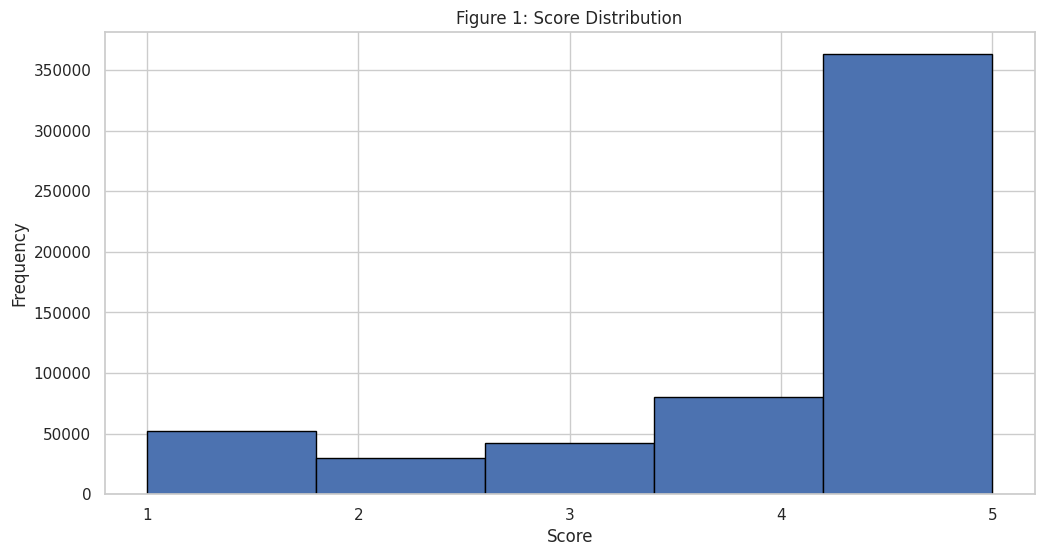

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Loading the dataset
df = pd.read_csv('/kaggle/input/amazon-review-dataset/Data/Reviews.csv')

# Setting plot size
plt.figure(figsize=(12, 6))

# Plotting the histogram
plt.hist(df['Score'], bins=5, edgecolor='black')

# Set up the labels and axis
plt.title('Figure 1: Score Distribution') 
plt.xlabel('Score') 
plt.ylabel('Frequency')
plt.xticks(range(1, 6))

# Show the plot
plt.show()

In [2]:
!pip install wordcloud

Figure 1 shows that the distribution of the scores is not uniform, which will have to be taken into account during preprocessing. This means that when we are creating our labels, we must either remove samples from categories with higher frequencies or add samples to the categories with low frequencies. Given we have limited computational resources, the more reasonable approach is to reduce the size of the dataset rather than increase it.

Next, we visualize a word cloud of the text in the reviews. This will give us a general understanding of the text content of the reviews, as well as reveal any problematic patterns found in the text. This can be seen in figure 2.

In [2]:
from wordcloud import WordCloud

# Word cloud for the text of the user reviews
text = ' '.join(df['Text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)


# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Plot the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')

# Set up axis and labels
plt.axis('off')
plt.title('Figure 2: Word Cloud of Reviews', fontsize = 18)

# Show the plot
plt.show()

KeyboardInterrupt: 

Figure 2 immediatly reveals a problem with the text in our dataset, which is the existence fo tags. This is the reason by "br" is written twice in such large letters. It also makes sense that words such as love, favourite, and treat are all included in this word cloud given the skewed distribution of the ratings. These two issues will be addressed in our data preprocessing.

Finally, Figure 3 shows the distribution of the lengths of the reviews in the dataset.

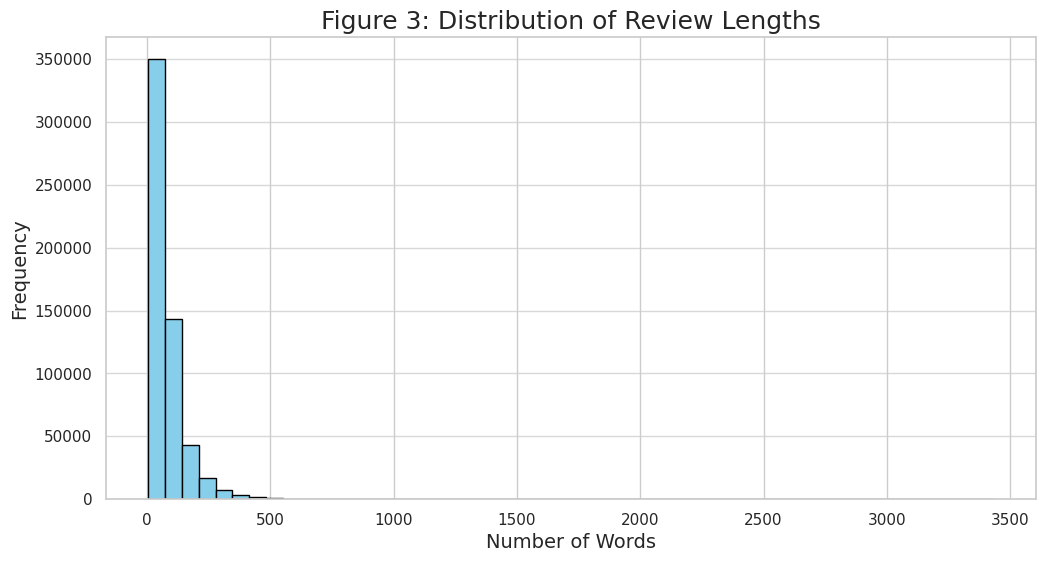

In [14]:
# Calculate the number of words in each review
df['ReviewLength'] = df['Text'].apply(lambda x: len(x.split()))

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the histogram
plt.hist(df['ReviewLength'], bins=50, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Figure 3: Distribution of Review Lengths', fontsize=18)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add grid lines for easier interpretation
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

Figure 3 shows that that the distribution of the lengths of reviews is heavily right skewed. Since the goal of the model is to gain insight into the sentiment of customers posting on social media posts which tend to be quite short (think YouTube comments or Tweets), it is reasonable to conclude that the lengths of the text is representitive of the content that the model will be used on. 

Though there are additional features included in the reviews dataset, the goal of this model is to categorize unstructured text from platforms such as Twitter and YouTube that do not contain information such as the helpfulness reviews or the product ID. Therefore, for the purposes of our model, we will only be using the text content of the reviews as the input for fine-tuning our model and the score for creating the labels.

### 5. Our Pipeline

Provide a **detailed overview** of the pipeline for the project. This pipeline should include:

- **Data preprocessing steps**: How are you cleaning and preparing the data?
- **Modeling process**: How are you selecting and training the model?
- **Post-processing**: What steps will you take after obtaining model predictions?

##### 5.1 Data Preprocessing

The first step in the data pre-processing is to remove all the features that we will not be using for fine-tuning our model.

In [15]:
# Make a backup of the original dataframe
df_backup = df.copy()

# List of columns to keep
columns_to_keep = ['Text', 'Score']

# Drop all other columns
df_selected = df.drop(columns=[col for col in df.columns if col not in columns_to_keep])

# Display the first few rows to verify
print(df_selected.head())

   Score                                               Text
0      5  I have bought several of the Vitality canned d...
1      1  Product arrived labeled as Jumbo Salted Peanut...
2      4  This is a confection that has been around a fe...
3      2  If you are looking for the secret ingredient i...
4      5  Great taffy at a great price.  There was a wid...


Next, we want our model to predict whether a review is negative, neutral, or positive. To do this, we make a score of 1 or 2 represent a review with negative sentiment, a score of 3 represent a review with neutral sentiment, and a review of 4 or 5 to represent a review with positive sentiment.

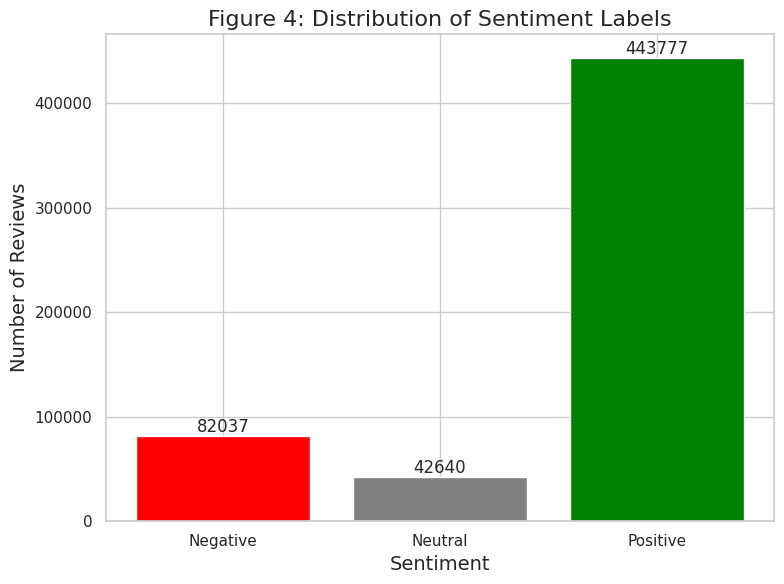

In [16]:
import seaborn as sns

# Make the background of the plot a whtie grid
sns.set(style="whitegrid")

# Define the mapping from Score to label
score_to_label = {
    1: 0,  # Negative sentiment
    2: 0,  # Negative sentiment
    3: 1,  # Neutral sentiment
    4: 2,  # Positive sentiment
    5: 2   # Positive sentiment
}

# Create the 'label' column
df_selected['label'] = df_selected['Score'].map(score_to_label)

# Create a chart to visualize the newly created 'label' column

# Count the occurrences of each label
label_counts = df_selected['label'].value_counts().sort_index()

#Define label names for better readability
label_names = ['Negative', 'Neutral', 'Positive']

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(label_names, label_counts, color=['red', 'gray', 'green'])

# Add titles and labels
plt.title('Figure 4: Distribution of Sentiment Labels', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, 
             f'{height}', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

Figure 4 shows the distribution of each label. This plot illustrates the already known issue that we do not have a uniform distribution of the different review sentiments. We fix this by randomly selecting 42,640 samples from the "Positive" sentiment class and the "Negative" sentiment class and dropping the other rows. This fixes two problems for us. The first is the already mentioned non-uniform distribution of the sentiments. If we show our model signficantly more reviews with positive sentiments as opposed to negative or neutral sentiments, the final model will perform poorly when classifying new reviews with neutral or negative sentiment. The second issue it resolves is it reduces the size of our very large dataset. Due to computational limitations, it would be infeasible to use all the data in the original dataset. 

In [17]:
# Define the target number of samples per sentiment
target_count = 42640

# Set a random seed for reproducibility
random_state = 42

# Sample equal number of reviews for each sentiment
df_balanced = df_selected.groupby('label').apply(
    lambda x: x.sample(n=target_count, random_state=random_state)
).reset_index(drop=True)

# (Optional) Shuffle the balanced DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)

# Verify the distribution
print(df_balanced['label'].value_counts())

label
1    42640
0    42640
2    42640
Name: count, dtype: int64


/tmp/ipykernel_36/365355402.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_selected.groupby('label').apply(


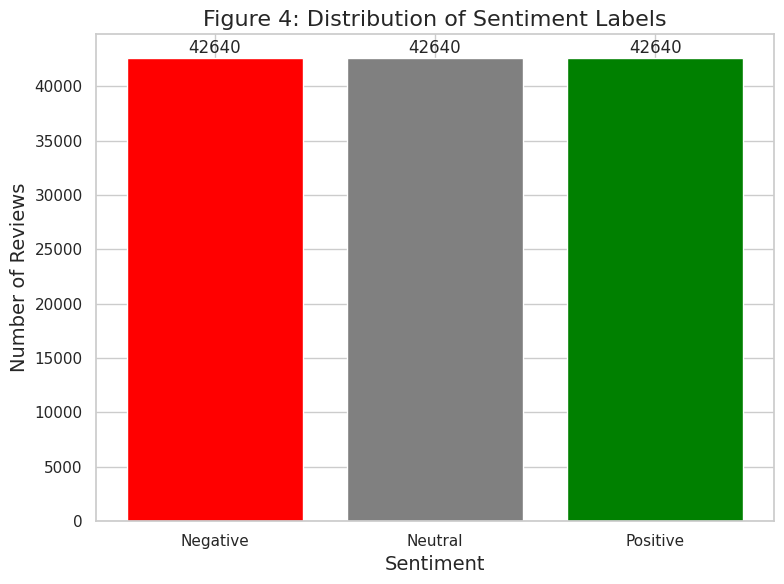

In [18]:
import seaborn as sns

# Make the background of the plot a whtie grid
sns.set(style="whitegrid")

# Define the mapping from Score to label
score_to_label = {
    1: 0,  # Negative sentiment
    2: 0,  # Negative sentiment
    3: 1,  # Neutral sentiment
    4: 2,  # Positive sentiment
    5: 2   # Positive sentiment
}

# Create the 'label' column
df_balanced['label'] = df_balanced['Score'].map(score_to_label)

# Create a chart to visualize the newly created 'label' column

# Count the occurrences of each label
label_counts = df_balanced['label'].value_counts().sort_index()

#Define label names for better readability
label_names = ['Negative', 'Neutral', 'Positive']

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(label_names, label_counts, color=['red', 'gray', 'green'])

# Add titles and labels
plt.title('Figure 4: Distribution of Sentiment Labels', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, 
             f'{height}', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

### 6. Training the Model

We will show the process of training and plotting the training (not exactly sure what she means by this since the next section is to plot the validation set and analyze the behaviour of training and validation, but we'll figure it out).

In [19]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import re

In [20]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and digits, keeping only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the cleaning function to the 'Text' column
df_balanced['Text'] = df_balanced['Text'].apply(clean_text)
df_balanced['Text'].head()

0    i have a bag of popchips everyday with lunch s...
1    if you like the flavor of rice crackers you ma...
2    honestly this gum lasts me for minutes i just ...
3    i bought the black pasta for halloween everybo...
4    cans come in a case i am caffeine sensitive so...
Name: Text, dtype: object

In [21]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# Only keep the relevant columns
df_cleaned = df_balanced[['Text', 'label']]

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_cleaned['Text'],
    df_cleaned['label'],
    test_size=0.2,
    random_state=42,
)

# Create DataFrames for training and validation sets
train_df = pd.DataFrame({'Text': train_texts, 'label': train_labels})
val_df = pd.DataFrame({'Text': val_texts, 'label': val_labels})

# Convert DataFrames to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Tokenizing function for the text data
def tokenize_function(examples):
    return tokenizer(examples["Text"], padding="max_length", truncation=True, max_length=512)

# Tokenize the datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

# Keep only the relevant columns in tokenized datasets
tokenized_train_dataset = tokenized_train_dataset.remove_columns(
    [col for col in tokenized_train_dataset.column_names if col not in ['label', 'input_ids', 'attention_mask']])
tokenized_val_dataset = tokenized_val_dataset.remove_columns(
    [col for col in tokenized_val_dataset.column_names if col not in ['label', 'input_ids', 'attention_mask']])


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/102336 [00:00<?, ? examples/s]

Map:   0%|          | 0/25584 [00:00<?, ? examples/s]

### 7. Plot Training accuracy vs. Validation Accuracy

Include an analysis of the Training vs. Validation accuracy of our model, and comment on whether or not the model is properly fit.

In [28]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np

# Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment-latest",
    num_labels=3,
    ignore_mismatched_sizes=True
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",  # Evaluate every N steps
    eval_steps=450,               # Set the number of steps for evaluation
    save_strategy="steps",        # Save model every 450 steps
    save_steps=450,                # Ensure this is a multiple of eval_steps,
    per_device_train_batch_size=16,  # Reduced batch size for training
    per_device_eval_batch_size=16,    # Reduced batch size for evaluation
    num_train_epochs=4,
    learning_rate=2e-5,          # Keep or adjust if necessary
    weight_decay=0.01,
    seed=42,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,                    # Enable mixed precision if supported
    gradient_accumulation_steps=4,  # Adjust to simulate larger batch size
    report_to="tensorboard",
)

# Custom metric computation function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = (preds == p.label_ids).mean()
    return {'accuracy': accuracy}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,  # Use tokenized train dataset
    eval_dataset=tokenized_val_dataset,      # Use tokenized validation dataset
    compute_metrics=compute_metrics          # Use custom metrics function
)

# Train the model
trainer.train()

# After training, you can plot the training/validation metrics
train_loss = trainer.state.log_history

# If you want to collect accuracy/loss for plotting, you can gather it as follows:
train_losses = [log['loss'] for log in train_loss if 'loss' in log]
eval_losses = [log['eval_loss'] for log in train_loss if 'eval_loss' in log]
eval_accuracies = [log['eval_accuracy'] for log in train_loss if 'eval_accuracy' in log]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/opt/conda/lib/python3.10/site-pack

Step,Training Loss,Validation Loss,Accuracy
450,0.493200,0.467747,0.808122
900,0.399300,0.426173,0.830324
1350,0.380000,0.412034,0.839157
1800,0.324700,0.417917,0.843691
2250,0.334500,0.401902,0.849320
2700,0.274900,0.415517,0.850414
3150,0.277700,0.415563,0.850297


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

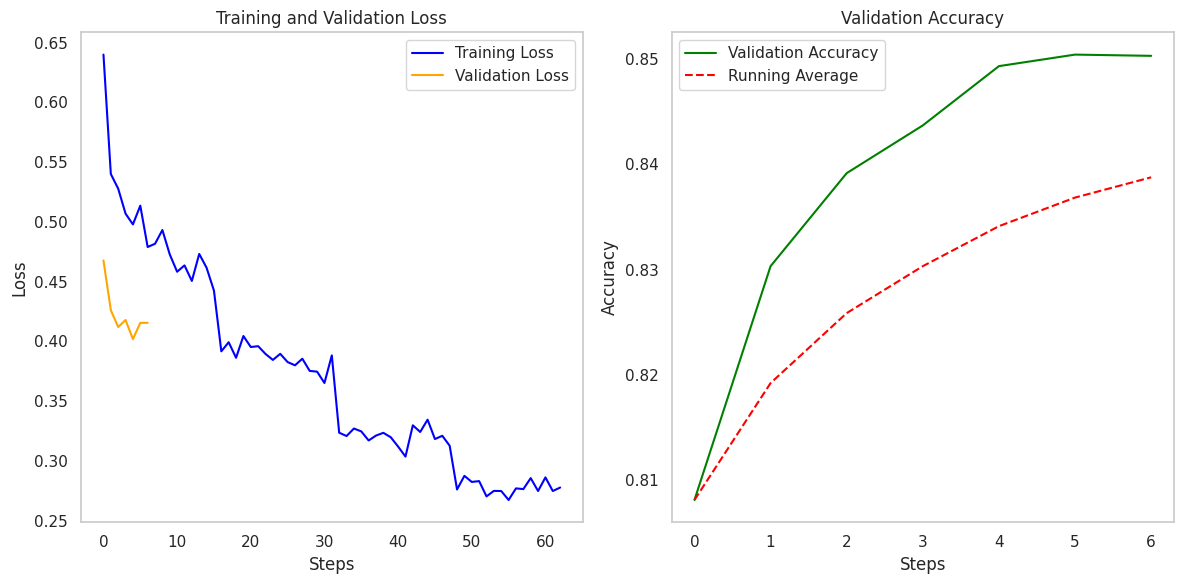

In [29]:
import matplotlib.pyplot as plt
# Plotting the metrics
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(eval_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(eval_accuracies, label='Validation Accuracy', color='green')
plt.plot([np.mean(eval_accuracies[:i]) for i in range(1, len(eval_accuracies) + 1)], 
         label='Running Average', color='red', linestyle='--')
plt.title('Validation Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [34]:
import numpy as np

avg_eval_loss = np.mean(eval_losses)
avg_eval_accuracy = np.mean(eval_accuracies)
best_eval_loss = min(eval_losses)
best_eval_accuracy = max(eval_accuracies)

print(f'Average Validation Loss: {avg_eval_loss}')
print(f'Average Validation Accuracy: {avg_eval_accuracy}')
print(f'Best Validation Loss: {best_eval_loss}')
print(f'Best Validation Accuracy: {best_eval_accuracy}')


Average Validation Loss: 0.422407512153898
Average Validation Accuracy: 0.8387608326632716
Best Validation Loss: 0.4019019305706024
Best Validation Accuracy: 0.8504143214509068


In [35]:
# Evaluate the model on the validation dataset
results = trainer.evaluate(tokenized_val_dataset)

# Print the evaluation metrics (accuracy and others you defined)
print(f"Evaluation results: {results}")


Evaluation results: {'eval_loss': 0.415517121553421, 'eval_accuracy': 0.8504143214509068, 'eval_runtime': 450.1201, 'eval_samples_per_second': 56.838, 'eval_steps_per_second': 1.777, 'epoch': 3.997498436522827}


In [45]:
# Evaluate the model on the test dataset
train_results = trainer.evaluate(tokenized_train_dataset)

# Print the test evaluation metrics
print(f"Test set results: {train_results}")


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test set results: {'eval_loss': 0.21943692862987518, 'eval_accuracy': 0.9210834896810507, 'eval_runtime': 1796.8635, 'eval_samples_per_second': 56.953, 'eval_steps_per_second': 1.78, 'epoch': 3.997498436522827}


In [39]:
predictions = trainer.predict(tokenized_val_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Compare predictions with true labels
print(f"Predictions: {preds}")
print(f"True labels: {predictions.label_ids}")


Predictions: [2 1 0 ... 2 0 0]
True labels: [2 1 0 ... 2 0 1]


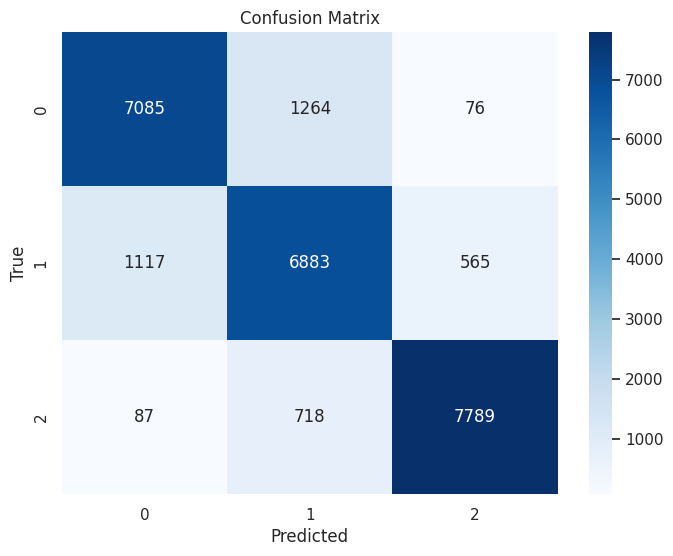

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(predictions.label_ids, preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [42]:
# Confusion matrix breakdown
confusion_matrix = np.array([[7085, 1264, 76], 
                             [1117, 6883, 565], 
                             [87, 718, 7789]])

# True Positives (TP) are the diagonal elements
TP = np.diag(confusion_matrix)

# False Positives (FP) are the sum of columns minus the True Positives
FP = np.sum(confusion_matrix, axis=0) - TP

# False Negatives (FN) are the sum of rows minus the True Positives
FN = np.sum(confusion_matrix, axis=1) - TP

# Precision: TP / (TP + FP)
precision = TP / (TP + FP)

# Recall: TP / (TP + FN)
recall = TP / (TP + FN)

# F1 Score: 2 * (precision * recall) / (precision + recall)
f1 = 2 * (precision * recall) / (precision + recall)

# Print the results
print(f"Precision for each class: {precision}")
print(f"Recall for each class: {recall}")
print(f"F1-Score for each class: {f1}")

# Alternatively, to summarize in a table-like structure:
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"Class {i}: Precision: {p:.2f}, Recall: {r:.2f}, F1-Score: {f:.2f}")


Precision for each class: [0.85474726 0.77642414 0.92396204]
Recall for each class: [0.84094955 0.80361938 0.90633   ]
F1-Score for each class: [0.84779227 0.78978772 0.91506109]
Class 0: Precision: 0.85, Recall: 0.84, F1-Score: 0.85
Class 1: Precision: 0.78, Recall: 0.80, F1-Score: 0.79
Class 2: Precision: 0.92, Recall: 0.91, F1-Score: 0.92


### 8. Our Inference Pipeline

Write an inference pipeline and explain how it works in detail.

### 9. Team Members Reflection

Andre:

Adnan:

Majed

Yonotan:

Younes: 